In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io, color, exposure
import skimage

from pathlib import Path

## Import normal peripheral blood cell dataset

In [2]:
path_name = '../../data/PBC_dataset_normal_df.csv'
path = Path(path_name)
df = pd.read_csv(path_name)
df.head()

,img_paths,id,label,height,width,mean_brightness
0,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,225079,MO,363,360,196.225564
1,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,582430,MO,363,360,196.672727
2,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,436409,MO,363,360,204.348235
3,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,648815,MO,363,360,199.038259
4,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,668574,MO,363,360,191.020018


In [3]:
#We now have 8 classes
classes = df['label'].unique()
classes

array(['MO', 'ERB', 'PLATELET', 'BA', 'IG', 'SNE', 'LY', 'EO'],
      dtype=object)

### Import images and store as a list of array

In [4]:
wrong_size_image = df[(df['height'] != 363) & (df['width'] != 360)]

In [5]:
# wrong_images = [io.imread(file) for file in wrong_size_image['img_paths']]

In [6]:
plt.imshow(wrong_images[9])

NameError: name 'wrong_images' is not defined

In [7]:
right_size_image = df[((df['height'] == 363) & (df['width'] == 360))]

In [8]:
%time
images = [io.imread(file) for file in right_size_image['img_paths']]

CPU times: user 8 µs, sys: 8 µs, total: 16 µs
Wall time: 29.8 µs


In [9]:
pd.Series([im.shape for im in images]).unique()

array([(363, 360, 3)], dtype=object)

In [10]:
image_tosave = np.array(images)

In [11]:
np.savez_compressed(Path('../../data/images_np/PBC_dataset_normal'), np.array(image_tosave), allow_pickle=True)

KeyboardInterrupt: 

In [21]:
images = np.load(Path('../../data/images_np/PBC_dataset_normal.npz'),allow_pickle=True)

In [22]:
len(images)

16839

In [23]:
test = images[420]

In [24]:
test

array(['../../data/PBC_dataset_normal_DIB/monocyte/MO_865250.jpg', 865250,
       'MO', 363, 360, 186.72319661259056, 0.7152123062472617],
      dtype=object)

TypeError: Image data of dtype object cannot be converted to float

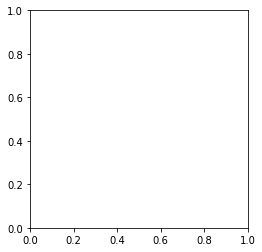

In [8]:
plt.imshow(images[420])

## Analysis of brightness/luminance

In [8]:
def plot_gray(idx, plot_gray=False):
    
    im = images[idx]
    gray = color.rgb2gray(im)
    histo, histo_centers = exposure.histogram(gray)
    
    fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

    if plot_gray:
        ax[0].imshow(gray, cmap='gray')
    else: ax[0].imshow(im)

    ax[1].plot(histo_centers, histo, lw=2)
    ax[1].set_title('Gray-level histogram')

    plt.suptitle(df.loc[idx]['label'])
    plt.tight_layout()
    plt.show()
    return gray, histo, histo_centers, fig

In [ ]:
# gray_images = [color.rgb2gray(im) for im in images]

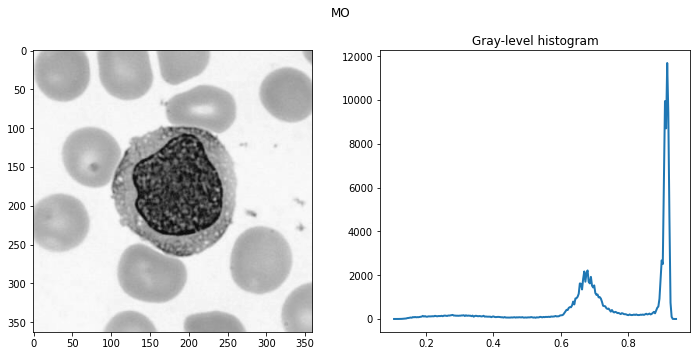

In [14]:
gray_test, histo, histo_centers, fig = plot_gray(420, plot_gray=True) # normalised

### Mean luminance calcul

In [9]:
df['mean_luminance'] = [np.mean(color.rgb2gray(im)) for im in images]

<AxesSubplot:xlabel='mean_luminance', ylabel='Density'>

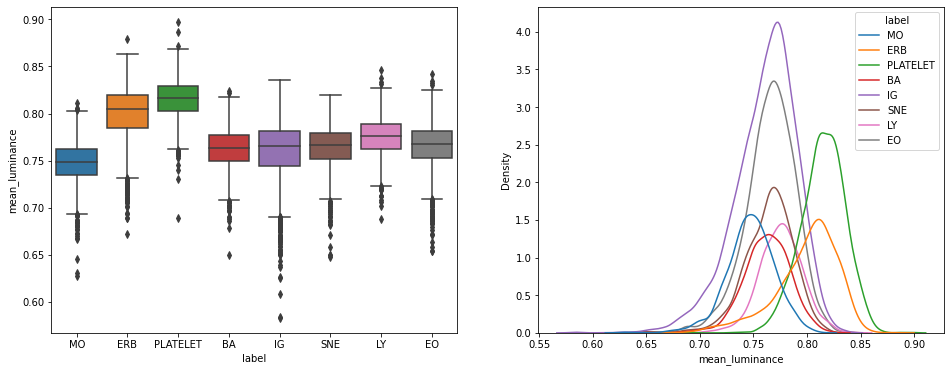

In [16]:
plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
sns.boxplot(x = "label", y = "mean_luminance", data = df)

plt.subplot(1,2,2)
sns.kdeplot(x = "mean_luminance", hue = "label", data = df)

## Deconvolution

In [10]:
def plot_deconv(idx, method):
    
    im = images[idx]
    deconv = color.separate_stains(im, method)

    fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(15, 15))
    ax[0, 0].imshow(deconv[..., 0], cmap='Purples')
    hist, hist_centers = exposure.histogram(deconv[..., 0])
    ax[0, 1].plot(hist_centers, hist, lw=2)
    
    ax[1, 0].imshow(deconv[..., 1], cmap='pink_r')
    hist, hist_centers = exposure.histogram(deconv[..., 1])
    ax[1, 1].plot(hist_centers, hist, lw=2)
    
    ax[2, 0].imshow(deconv[..., 2], cmap='RdPu_r')
    hist, hist_centers = exposure.histogram(deconv[..., 2])
    ax[2, 1].plot(hist_centers, hist, lw=2)
    
    plt.show()

    return deconv, fig

In [120]:
methods = [color.bex_from_rgb, color.bpx_from_rgb, color.bro_from_rgb, 
           #color.gdx_from_rgb, color.hax_from_rgb, color.hdx_from_rgb, 
           color.hed_from_rgb, color.hpx_from_rgb, color.rbd_from_rgb]

1


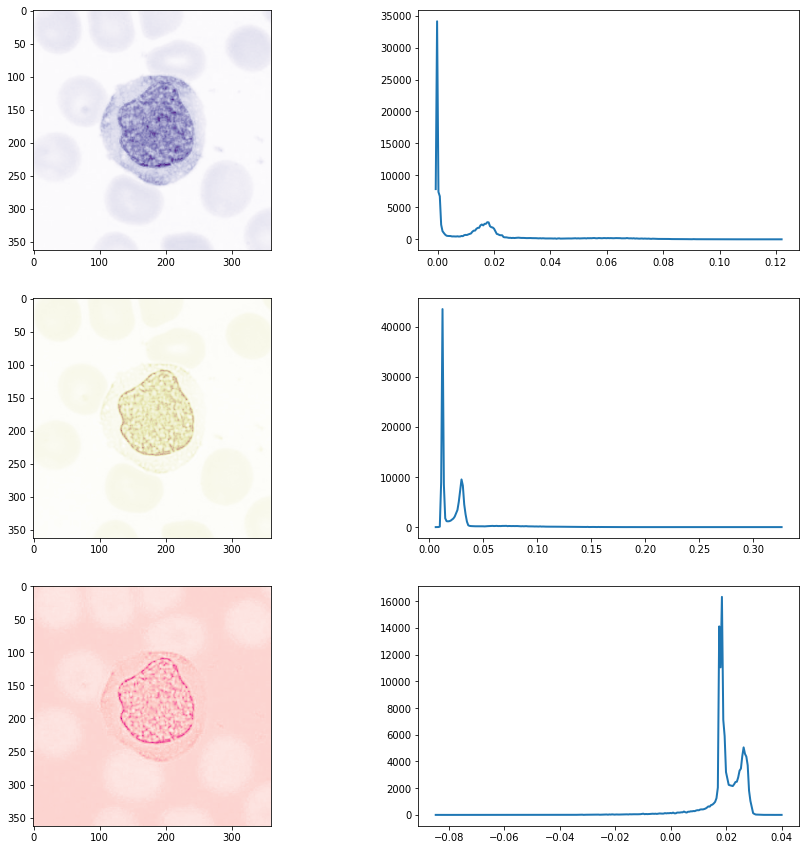

2


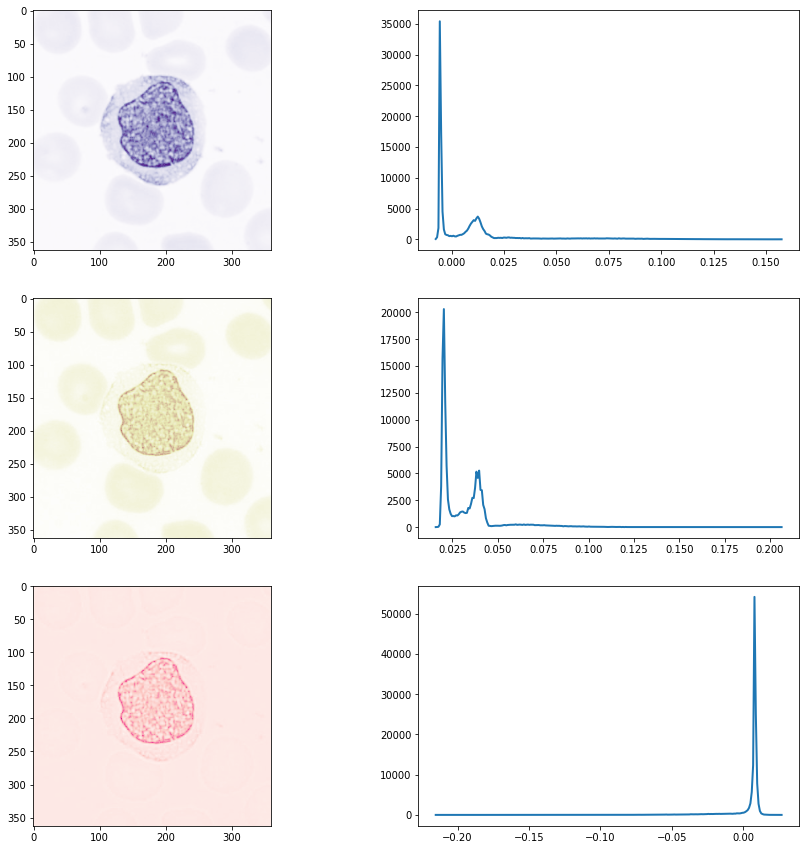

3


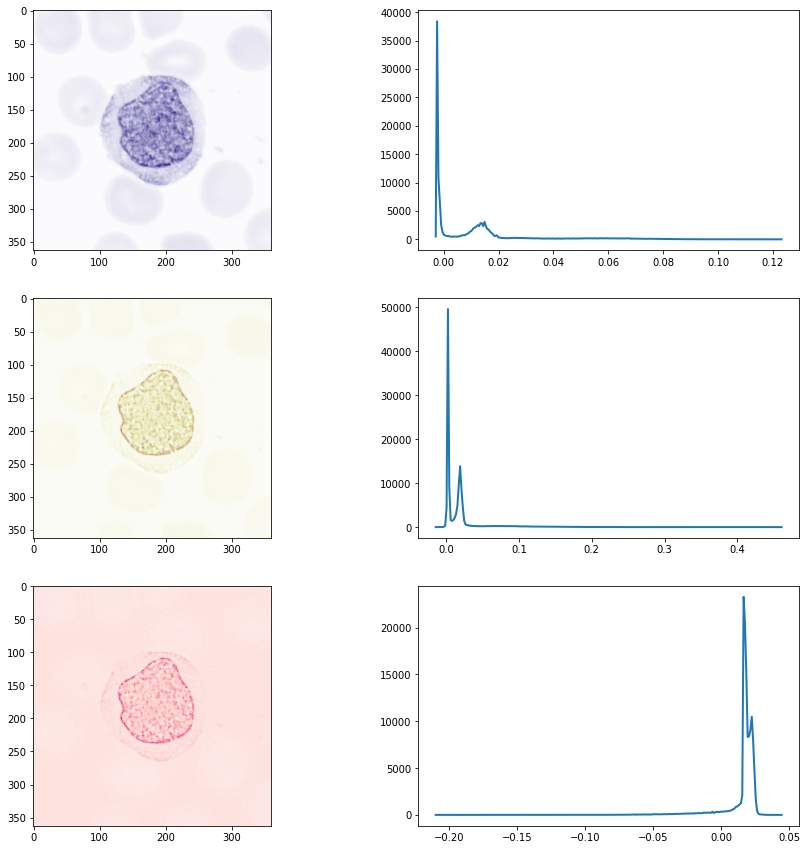

4


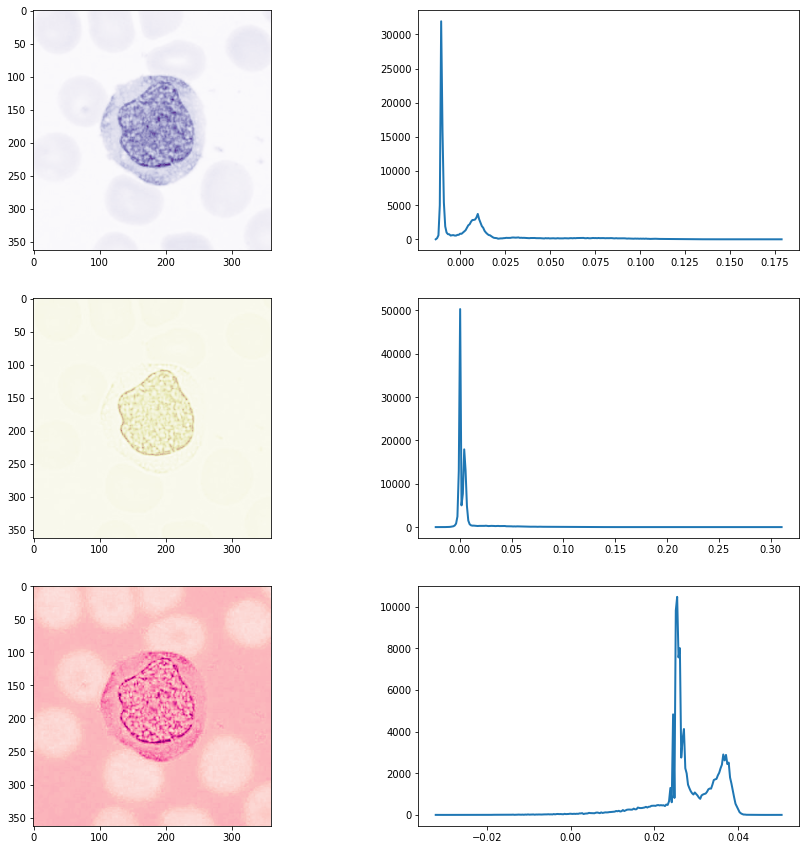

5


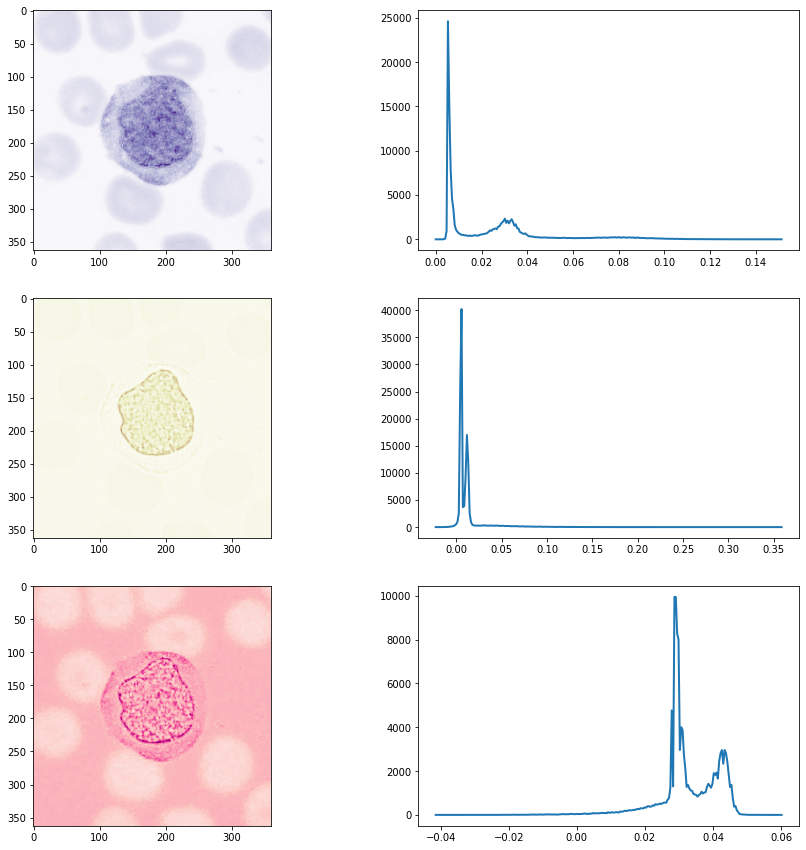

6


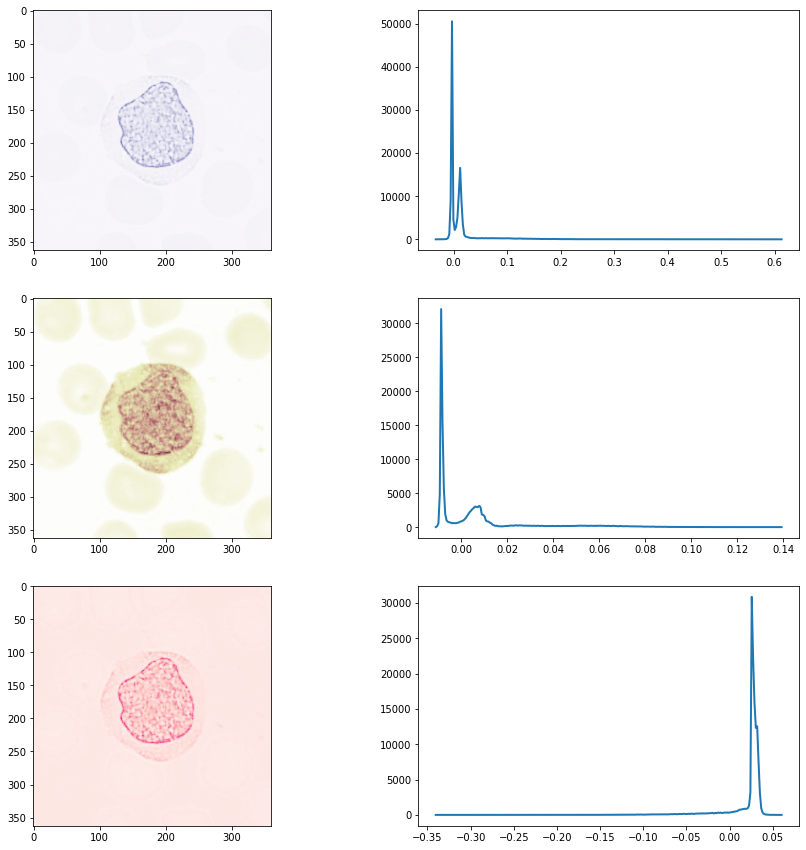

In [121]:
for i, method in enumerate(methods):
    print(i+1)
    plot_deconv(420, method)

The staining seems best deconvolved from the background with `bpx` (methyl blue + ponceau).

Let's compare high and low brightness for large cells and small cells

In [11]:
df['label'].unique()[-1]

'EO'

In [18]:
def im_for_label(label):
    temp_df = df[(df['label'] == label) & (df['height'] == 363) & (df['width'] == 360)]
    temp_im = np.array([io.imread(file) for file in temp_df['img_paths']])
    
    return temp_im

In [ ]:
im_by_cell = {}

for label in df['label'].unique():
    print(label)
    im_by_cell[label] = im_for_label(label)


MO
ERB
PLATELET
BA
IG
SNE
LY
EO


In [ ]:
for cell, arr in im_by_cell.items():
    print(im_by_cell[cell].shape)
    plt.imshow(color.rgb2gray(np.array(arr).mean(axis=0)))
    plt.title(f'mean gray value for {cell}')
    plt.show()

In [21]:
im_for_label('MO')

array([[[[231, 203, 181],
         [225, 197, 176],
         [219, 187, 172],
         ...,
         [210, 175, 171],
         [208, 173, 169],
         [207, 172, 170]],

        [[238, 210, 188],
         [232, 204, 183],
         [227, 196, 178],
         ...,
         [209, 174, 170],
         [208, 173, 169],
         [206, 171, 169]],

        [[246, 218, 194],
         [242, 214, 192],
         [237, 206, 186],
         ...,
         [208, 173, 169],
         [207, 172, 168],
         [205, 170, 168]],

        ...,

        [[210, 171, 166],
         [209, 169, 167],
         [208, 168, 169],
         ...,
         [234, 203, 183],
         [233, 202, 182],
         [232, 201, 181]],

        [[210, 171, 166],
         [209, 169, 167],
         [208, 168, 169],
         ...,
         [234, 203, 183],
         [233, 202, 182],
         [232, 201, 181]],

        [[210, 171, 166],
         [209, 169, 167],
         [208, 168, 169],
         ...,
         [234, 203, 183],
        

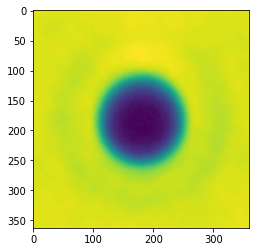

In [28]:
plt.imshow(color.rgb2gray(np.array(mo_im).mean(axis=0)))

In [ ]:
fig, axes = plt.figure(20, 40)

for im, ax in zip()

In [ ]:

df_sombre_IG = df[(df["mean_brightness"] <= 170) & (df["label"] == "IG")]
df_sombre_ERB = df[(df["mean_brightness"] <= 185) & (df["label"]== "ERB")]

images_IG = random.choices(df_sombre_IG.index, k = 5)
images_ERB = random.choices(df_sombre_ERB.index, k = 5)

plt.figure(figsize = (20,8))

for i, f_IG, f_ERB in zip(range(5), images_IG, images_ERB):
 
    img_IG = plt.imread(df.loc[f_IG,"path"])
    img_ERB = plt.imread(df.loc[f_ERB,"path"])
    
    plt.subplot(3,5,i+1)
    plt.imshow(img_IG)
    
    plt.subplot(3,5,i+6)
    plt.imshow(img_ERB)

(array([3.0000e+00, 3.0000e+00, 1.0000e+00, 5.0000e+00, 6.0000e+00,
        6.0000e+00, 4.0000e+00, 8.0000e+00, 9.0000e+00, 1.9000e+01,
        3.2000e+01, 3.4000e+01, 3.8000e+01, 5.9000e+01, 7.1000e+01,
        8.5000e+01, 1.3600e+02, 1.6400e+02, 2.1700e+02, 2.3100e+02,
        2.4200e+02, 2.7000e+02, 2.9100e+02, 2.4800e+02, 2.3600e+02,
        2.2400e+02, 2.0300e+02, 2.1600e+02, 2.2800e+02, 2.4900e+02,
        2.2600e+02, 2.3500e+02, 2.3400e+02, 1.8900e+02, 1.9800e+02,
        1.7400e+02, 2.0500e+02, 1.6400e+02, 1.7500e+02, 1.4300e+02,
        1.5900e+02, 1.3000e+02, 1.1700e+02, 1.2500e+02, 9.5000e+01,
        1.1500e+02, 8.6000e+01, 7.7000e+01, 9.2000e+01, 8.6000e+01,
        1.0100e+02, 9.4000e+01, 9.6000e+01, 1.3200e+02, 1.4400e+02,
        1.6700e+02, 2.4400e+02, 2.9200e+02, 3.3100e+02, 3.8400e+02,
        4.1300e+02, 4.3600e+02, 4.2400e+02, 3.7100e+02, 3.6800e+02,
        3.3700e+02, 2.8700e+02, 2.7500e+02, 2.5100e+02, 2.0100e+02,
        2.1400e+02, 2.2700e+02, 1.8500e+02, 1.73

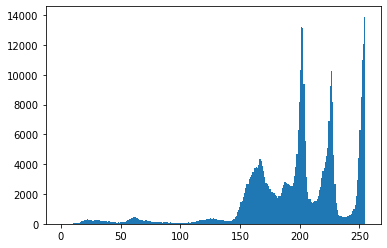

In [95]:
plt.hist(images[6162].ravel(), bins=256)